In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

##Load the CIFAR-10 dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=64


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 35003402.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


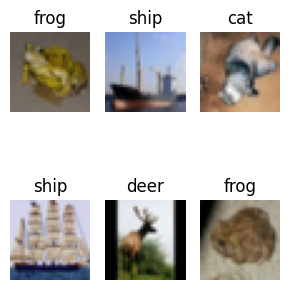

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Define the model architecture

In [5]:
import torch
import torch.nn as nn

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

model.fc = nn.Linear(512, 10)  # Define new fully connected layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 80.3MB/s]


## Define a Loss function and optimizer.
Using a Classification Cross-Entropy loss and Adam with momentum.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
num_epochs = 12
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/12, Loss: 1.3567, Train Accuracy: 0.5345, Val Accuracy: 0.6862
Epoch 2/12, Loss: 0.8115, Train Accuracy: 0.7386, Val Accuracy: 0.7247
Epoch 3/12, Loss: 0.6614, Train Accuracy: 0.7938, Val Accuracy: 0.7943
Epoch 4/12, Loss: 0.5637, Train Accuracy: 0.8224, Val Accuracy: 0.7686
Epoch 5/12, Loss: 0.5252, Train Accuracy: 0.8381, Val Accuracy: 0.7845
Epoch 6/12, Loss: 0.4654, Train Accuracy: 0.8606, Val Accuracy: 0.7858
Epoch 7/12, Loss: 0.4578, Train Accuracy: 0.8613, Val Accuracy: 0.7928
Epoch 8/12, Loss: 0.5006, Train Accuracy: 0.8527, Val Accuracy: 0.7999
Epoch 9/12, Loss: 0.3866, Train Accuracy: 0.8862, Val Accuracy: 0.8075
Epoch 10/12, Loss: 0.3863, Train Accuracy: 0.8900, Val Accuracy: 0.7933
Epoch 11/12, Loss: 0.3480, Train Accuracy: 0.9016, Val Accuracy: 0.7951
Epoch 12/12, Loss: 0.3352, Train Accuracy: 0.9080, Val Accuracy: 0.8050


##Saving our trained model

In [9]:
torch.save(model.state_dict(), 'cifar10_model.pth')

##Test the network on the test data
We have trained the network for 10 epoch over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

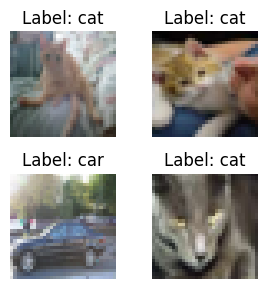

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


##Load the pre trained model

In [11]:
model.load_state_dict(torch.load('cifar10_model.pth'))

<All keys matched successfully>

In [12]:
# Assuming 'images' is your input tensor and 'model' is your neural network model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the same device as the input tensor
model = model.to(device)

# Move the input tensor to the same device as the model
images = images.to(device)

# Now perform the forward pass
outputs = model(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  dog   car   cat  


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        # Move the model to the same device as the input tensor
        model = model.to(device)

        # Move the input tensor to the same device as the model
        images = images.to(device)

        # Now perform the forward pass
        outputs = model(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        # Assuming 'labels' is your tensor containing the ground truth labels
        labels = labels.to(device)

        # Now you can perform the operation
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Move the model to the device
        model = model.to(device)

        # Move the input tensor to the same device as the model
        images = images.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    if classname in total_pred and total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'No predictions made or no test samples for class: {classname}')

Accuracy for class: plane is 79.5 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 74.7 %
Accuracy for class: cat   is 57.2 %
Accuracy for class: deer  is 77.9 %
Accuracy for class: dog   is 76.6 %
Accuracy for class: frog  is 84.9 %
Accuracy for class: horse is 89.4 %
Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 88.7 %


Success Rate: 0.5234


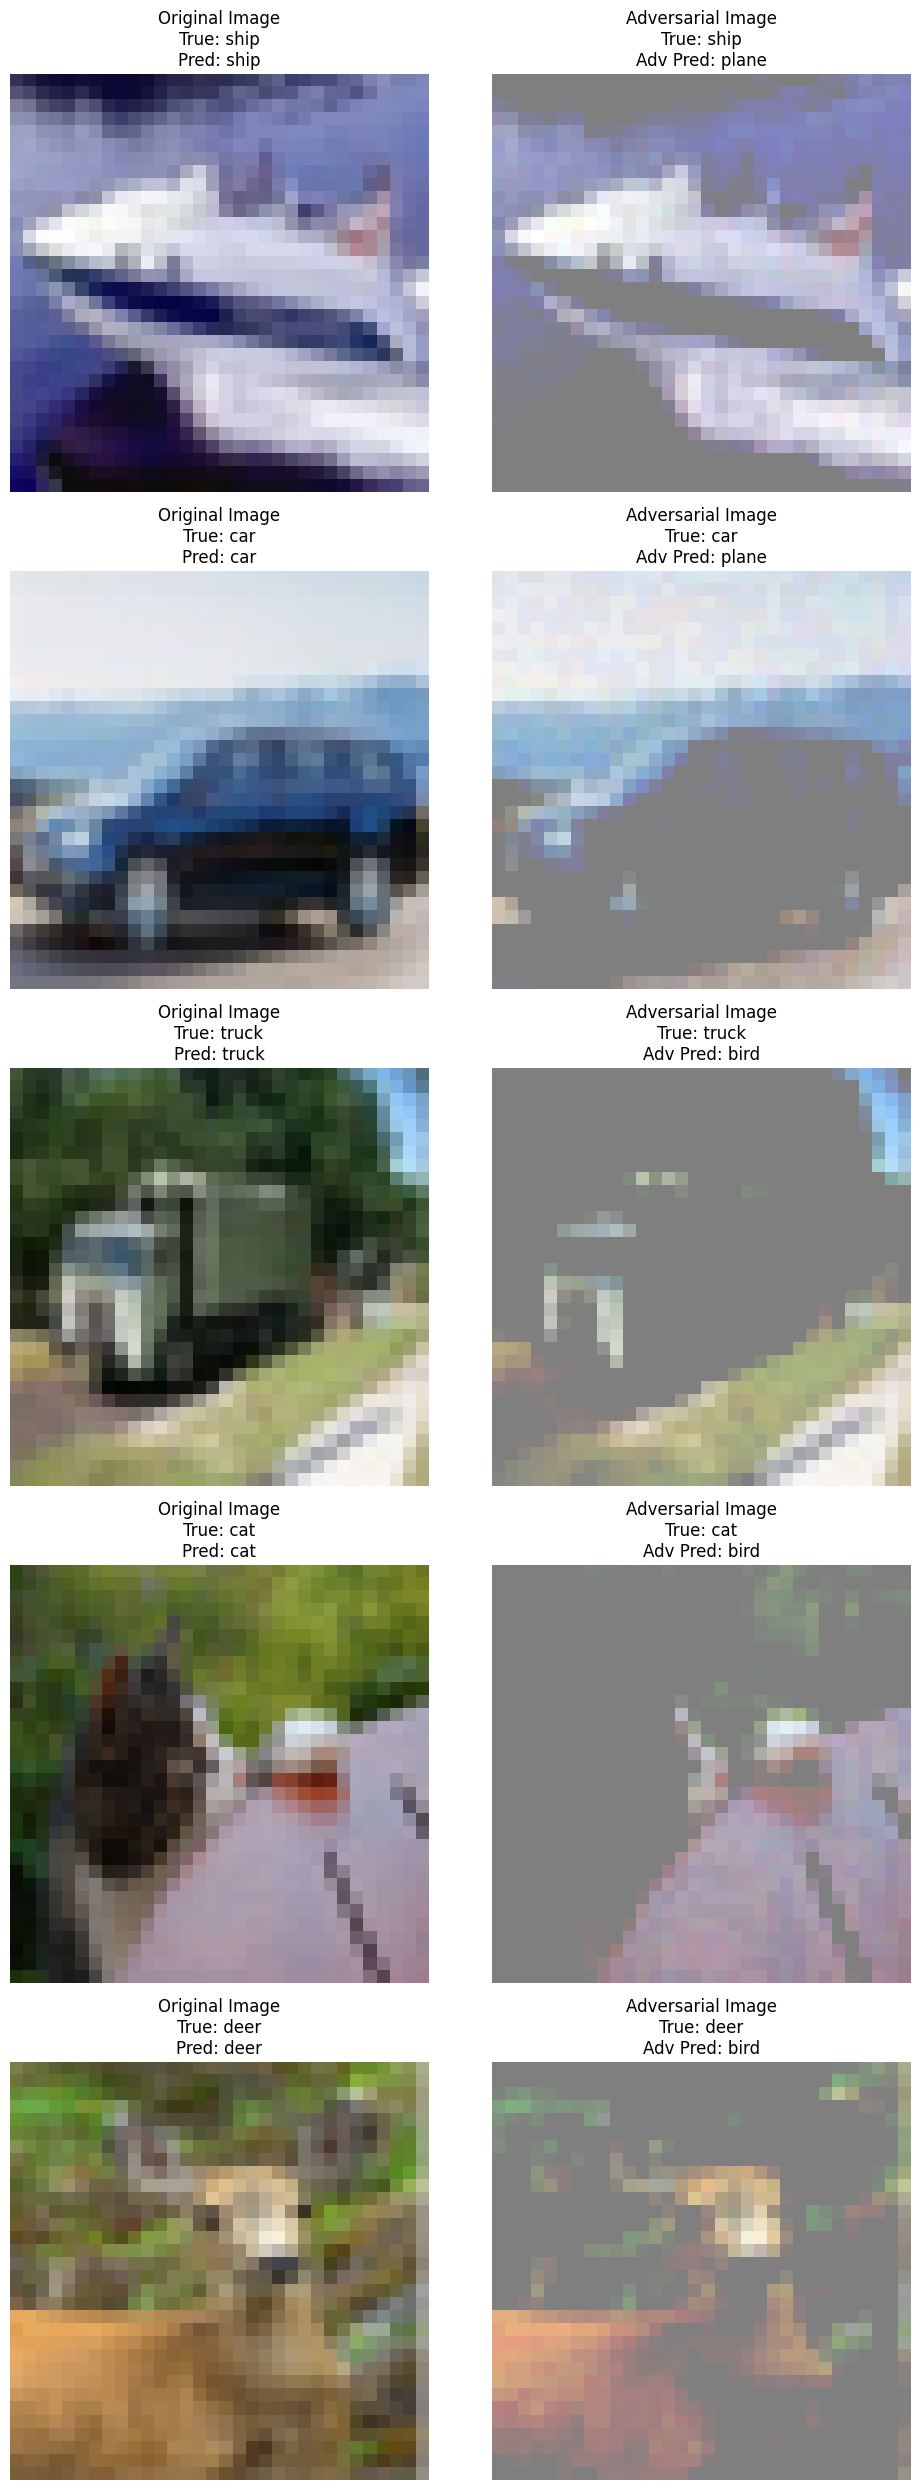

In [16]:
# FGSM Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the FGSM Attack
attack_fgsm = torchattacks.FGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_fgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.7625


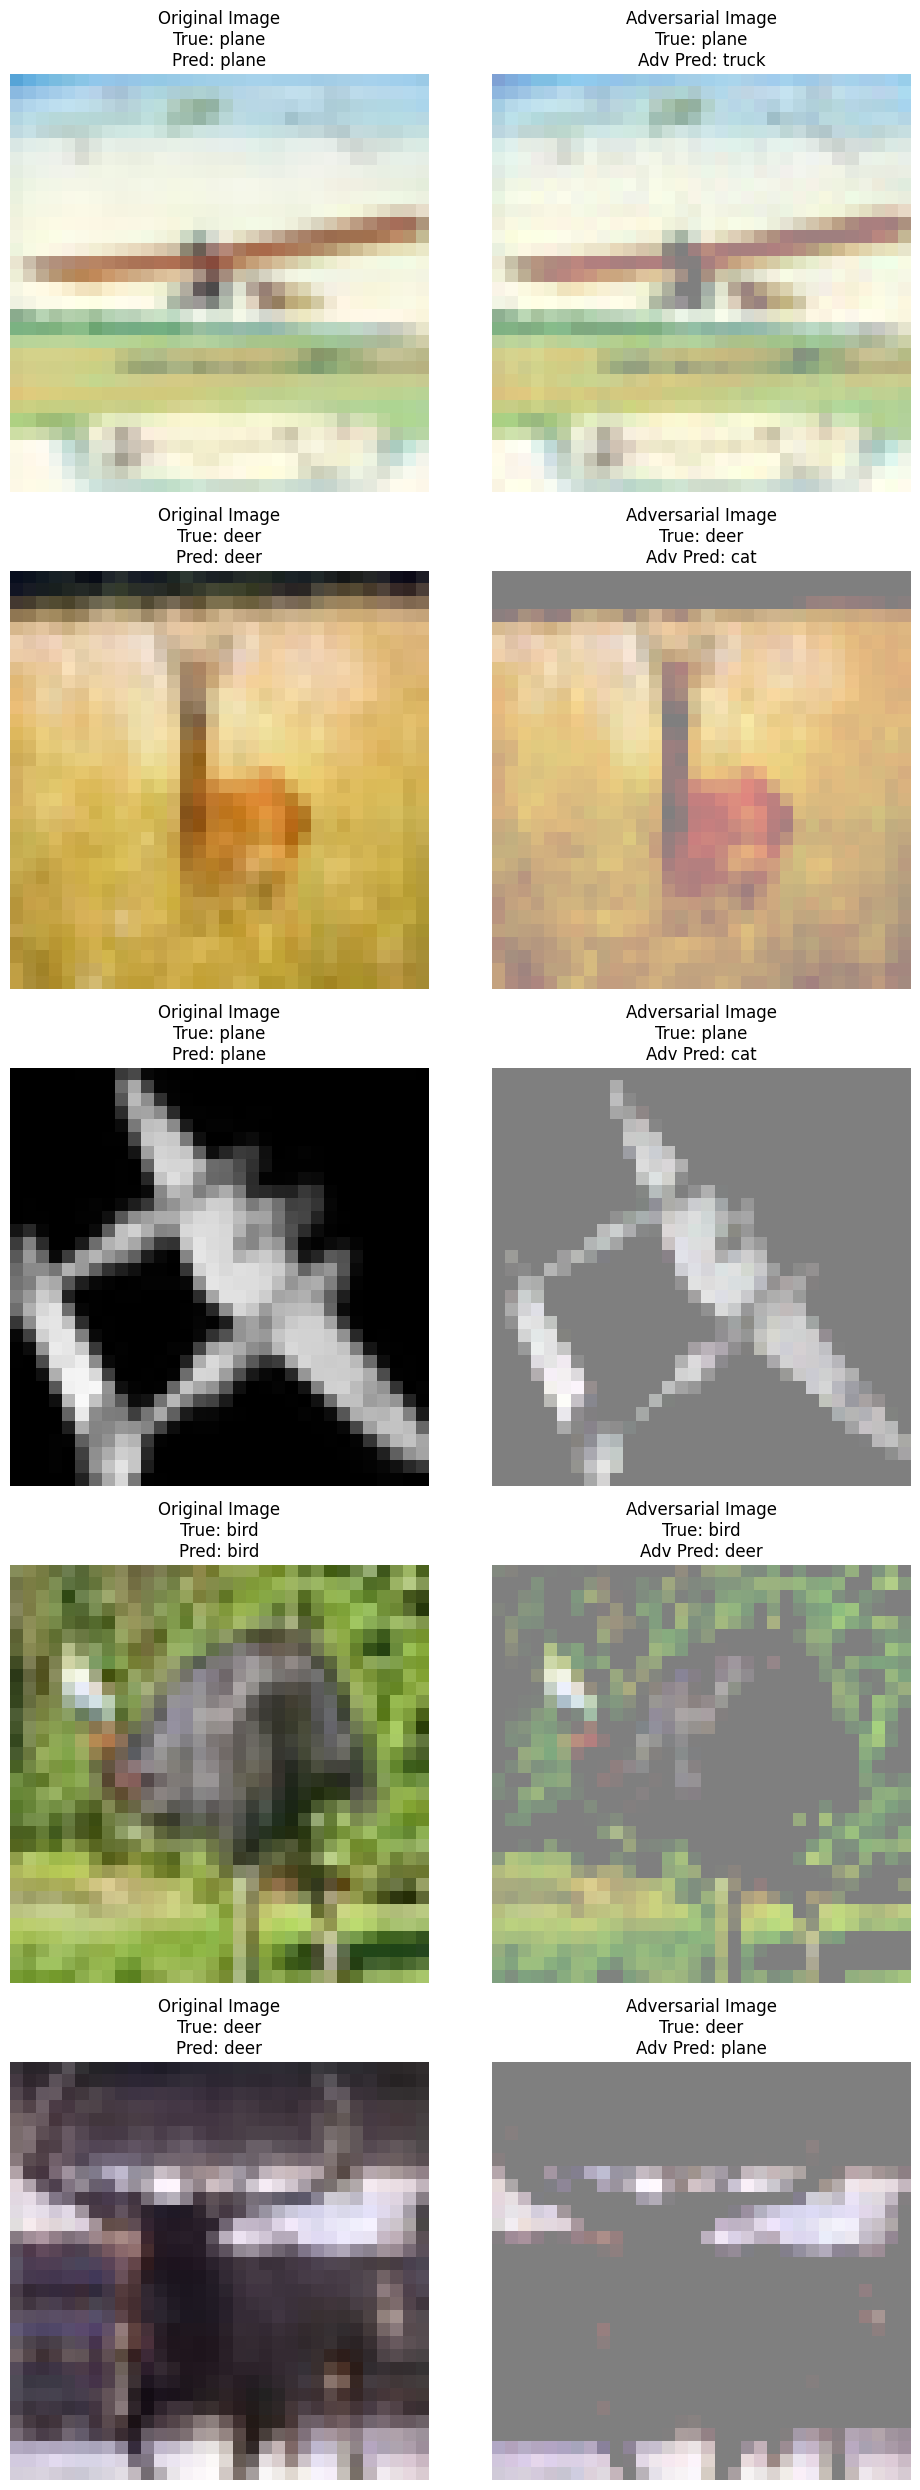

In [17]:
# RFGSM Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the FGSM Attack
attack_rfgsm = torchattacks.RFGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_rfgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.7703


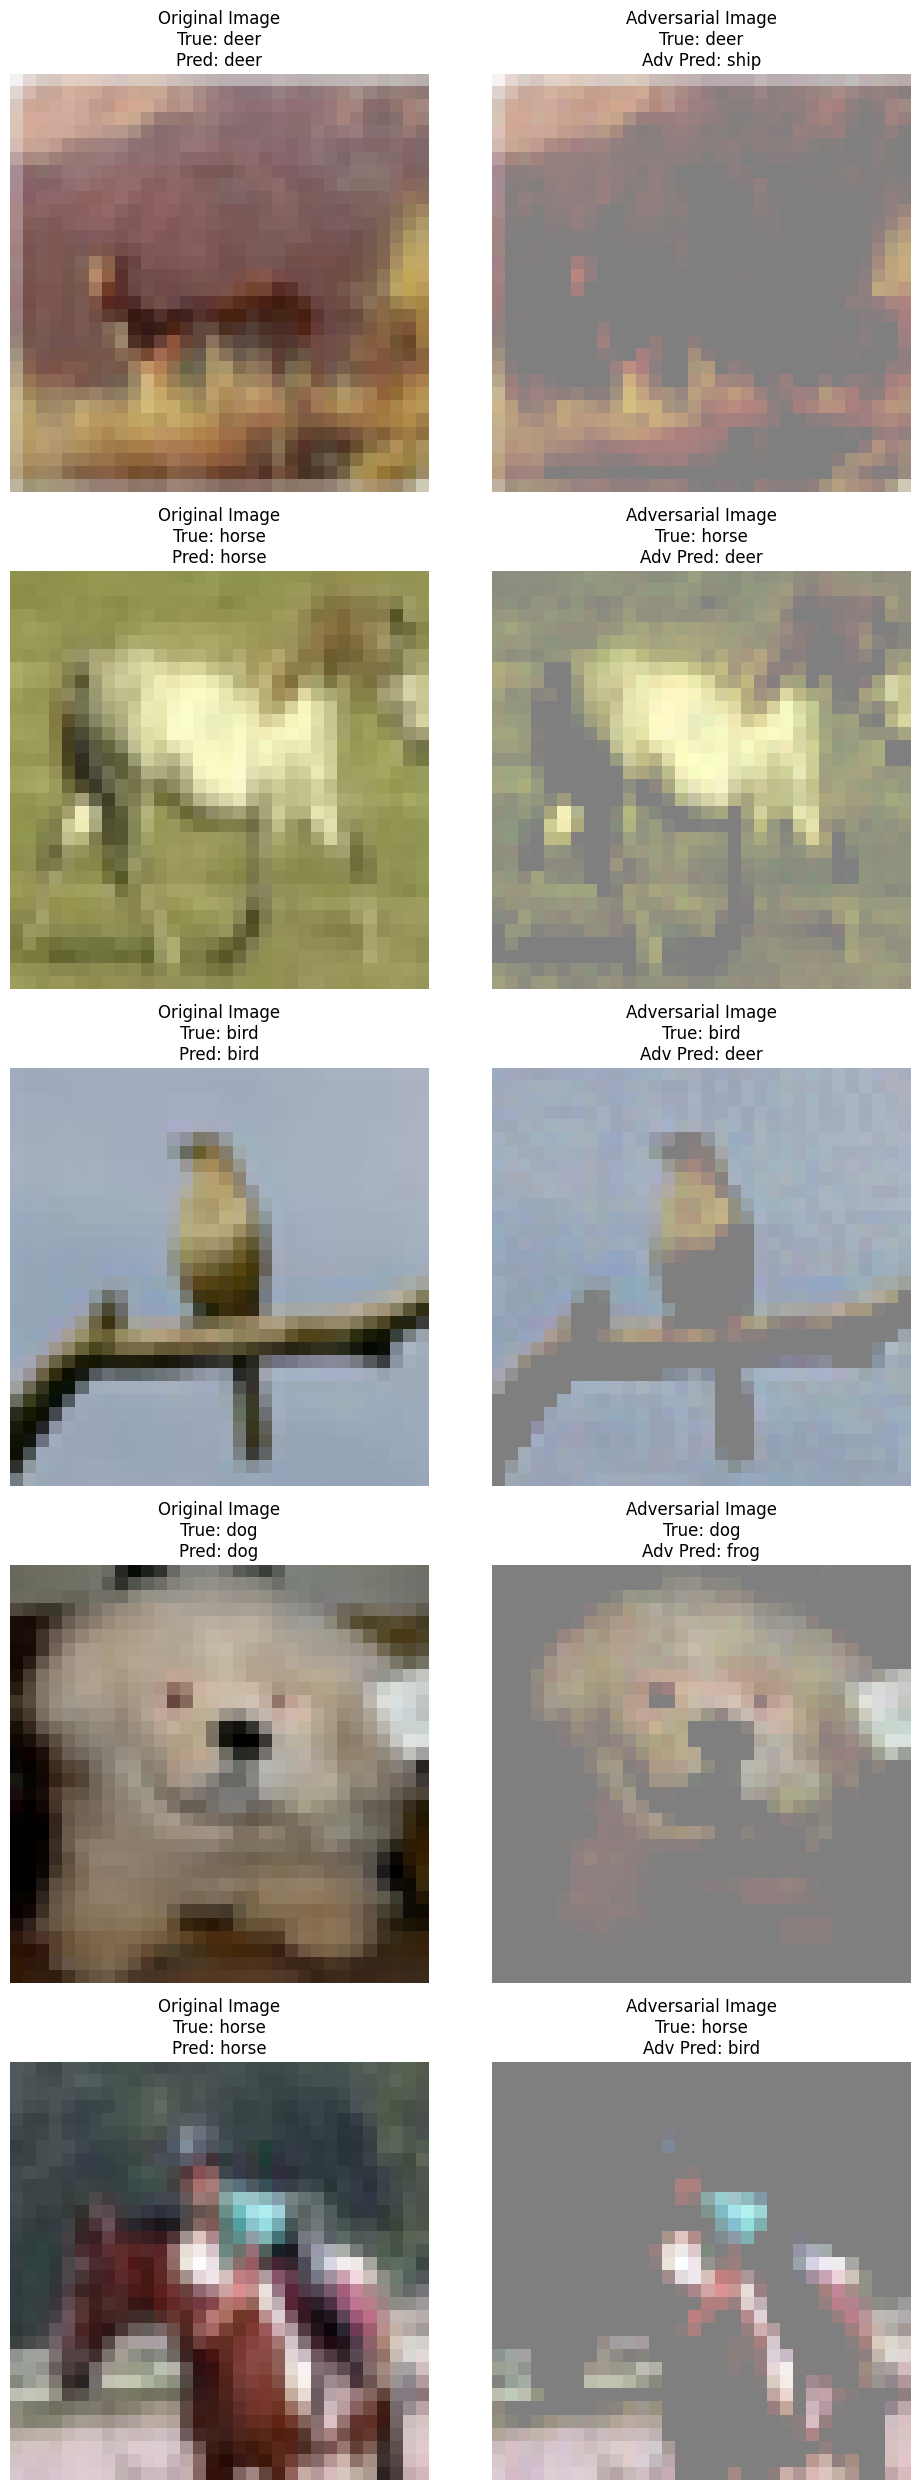

In [18]:
# PGD Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the PGD Attack
attack_pdg = torchattacks.PGD(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pdg(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.7922


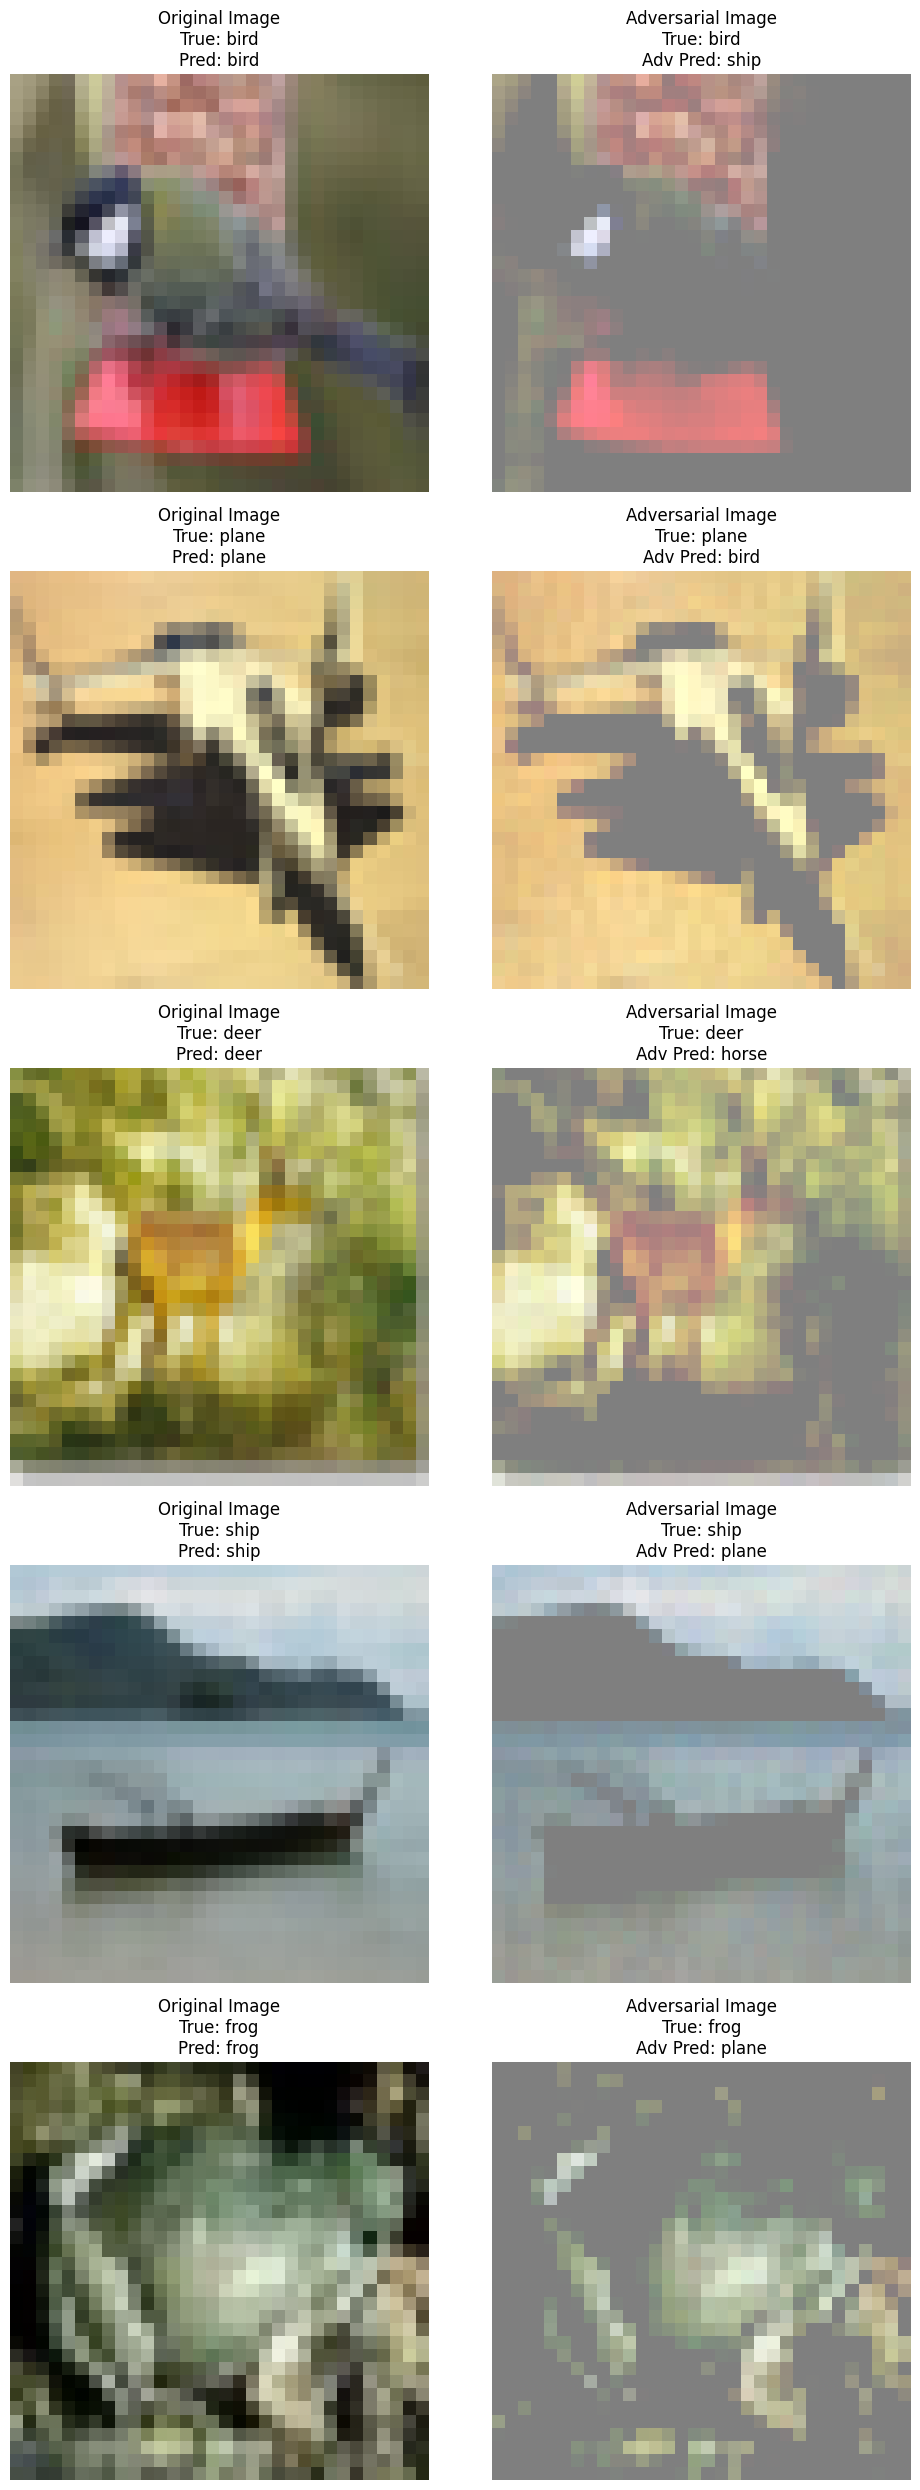

In [19]:
# EOTPGD Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the EOTPGD Attack
attack_eotpdg = torchattacks.EOTPGD(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_eotpdg(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.6891


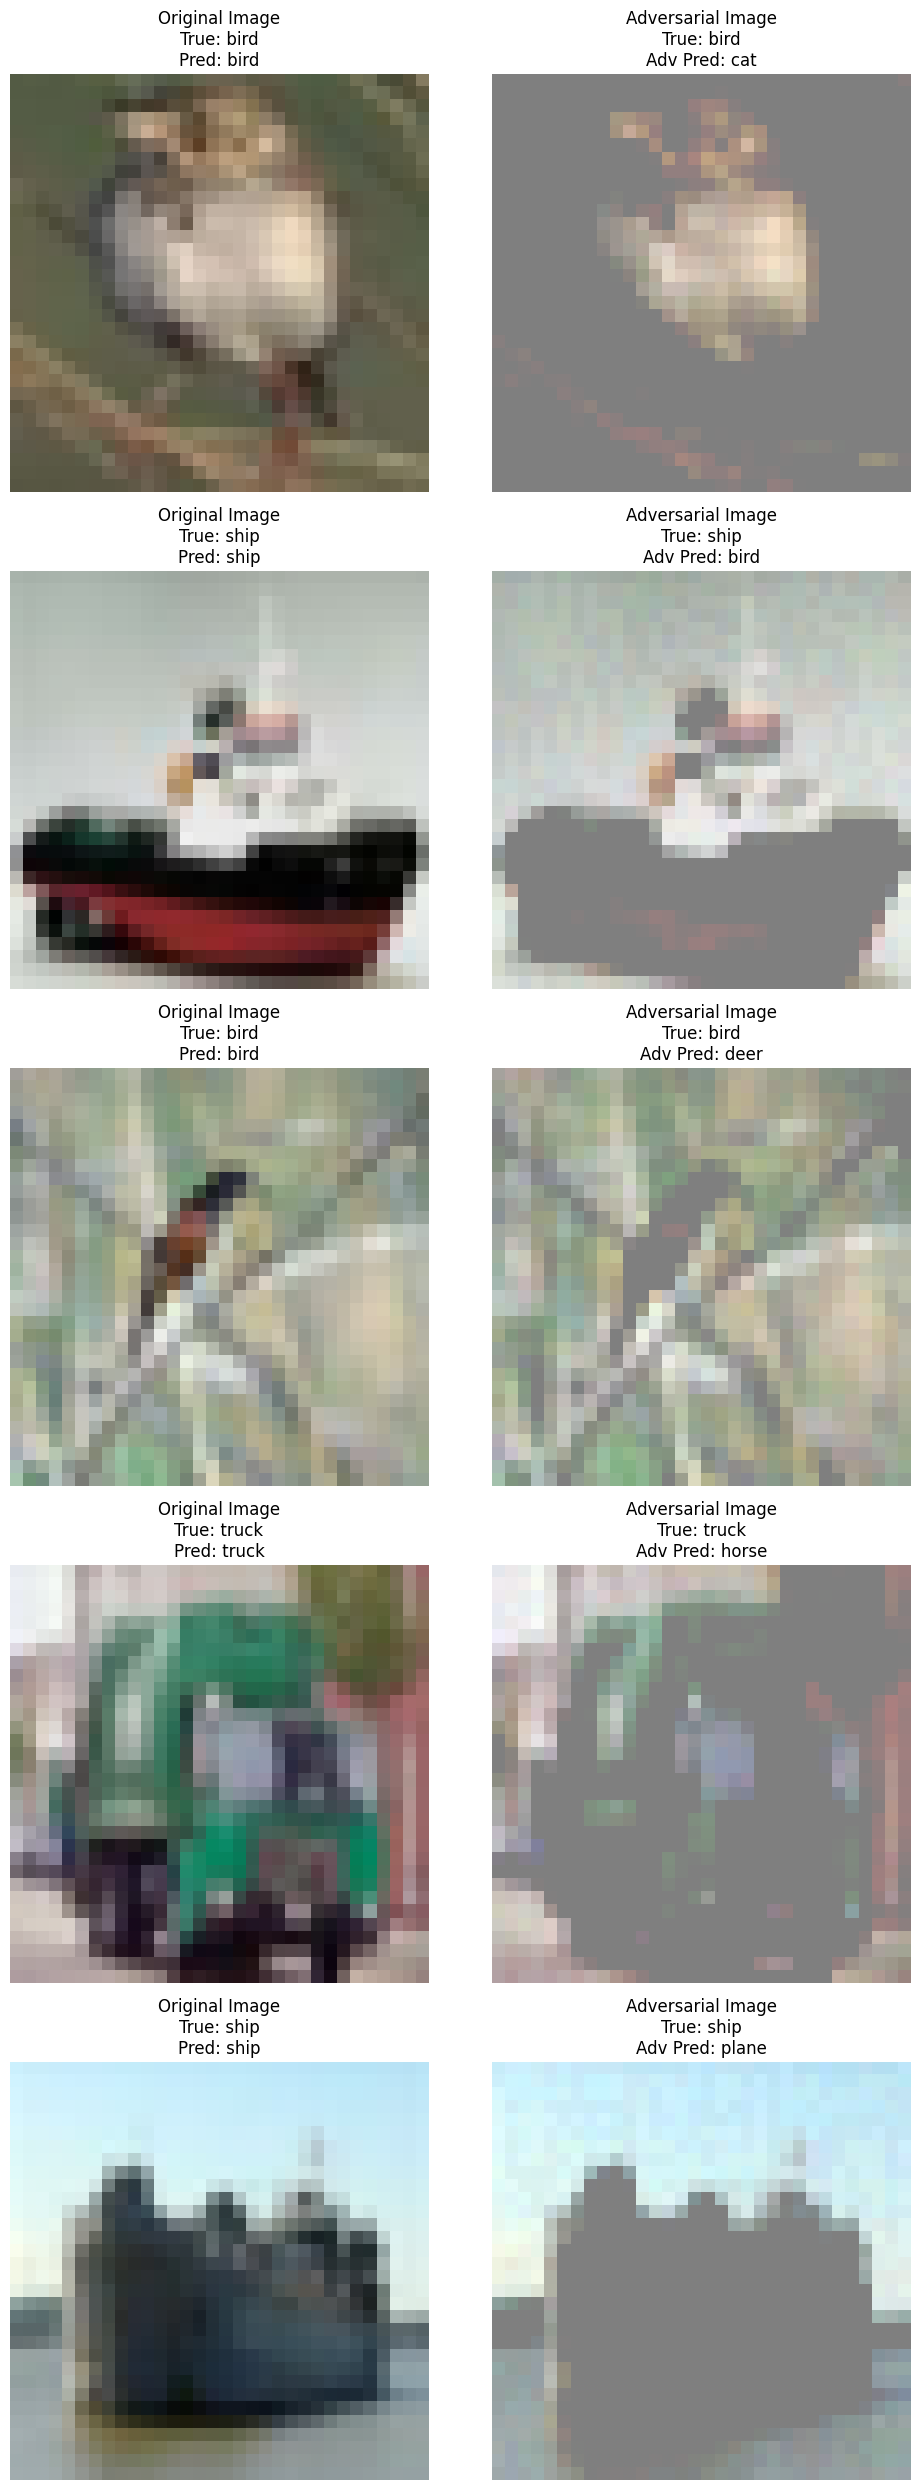

In [20]:
# FFGSM Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the FFGSM Attack
attack_ffgsm = torchattacks.FFGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_ffgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.7578


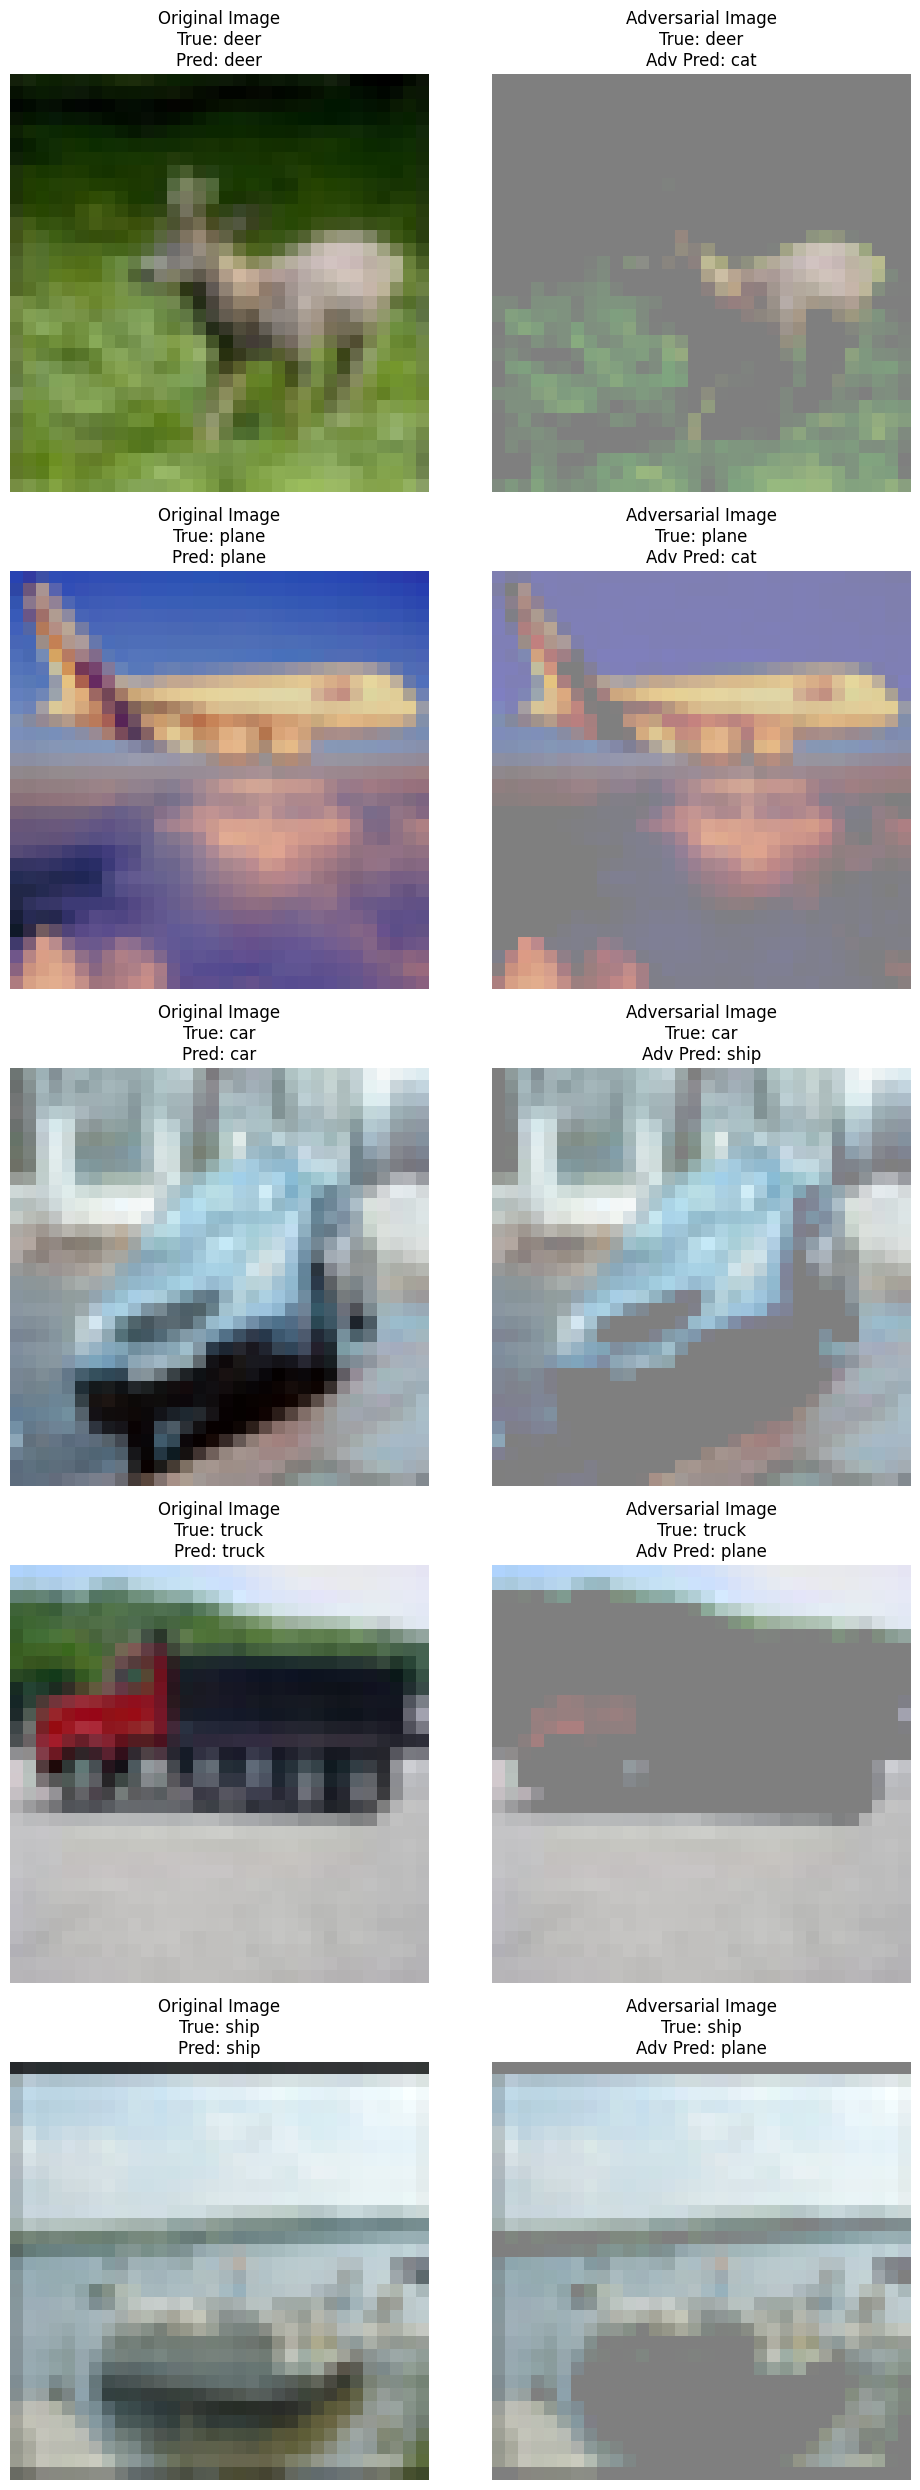

In [21]:
# CW Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the CW Attack
attack_cw = torchattacks.CW(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_cw(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.4062


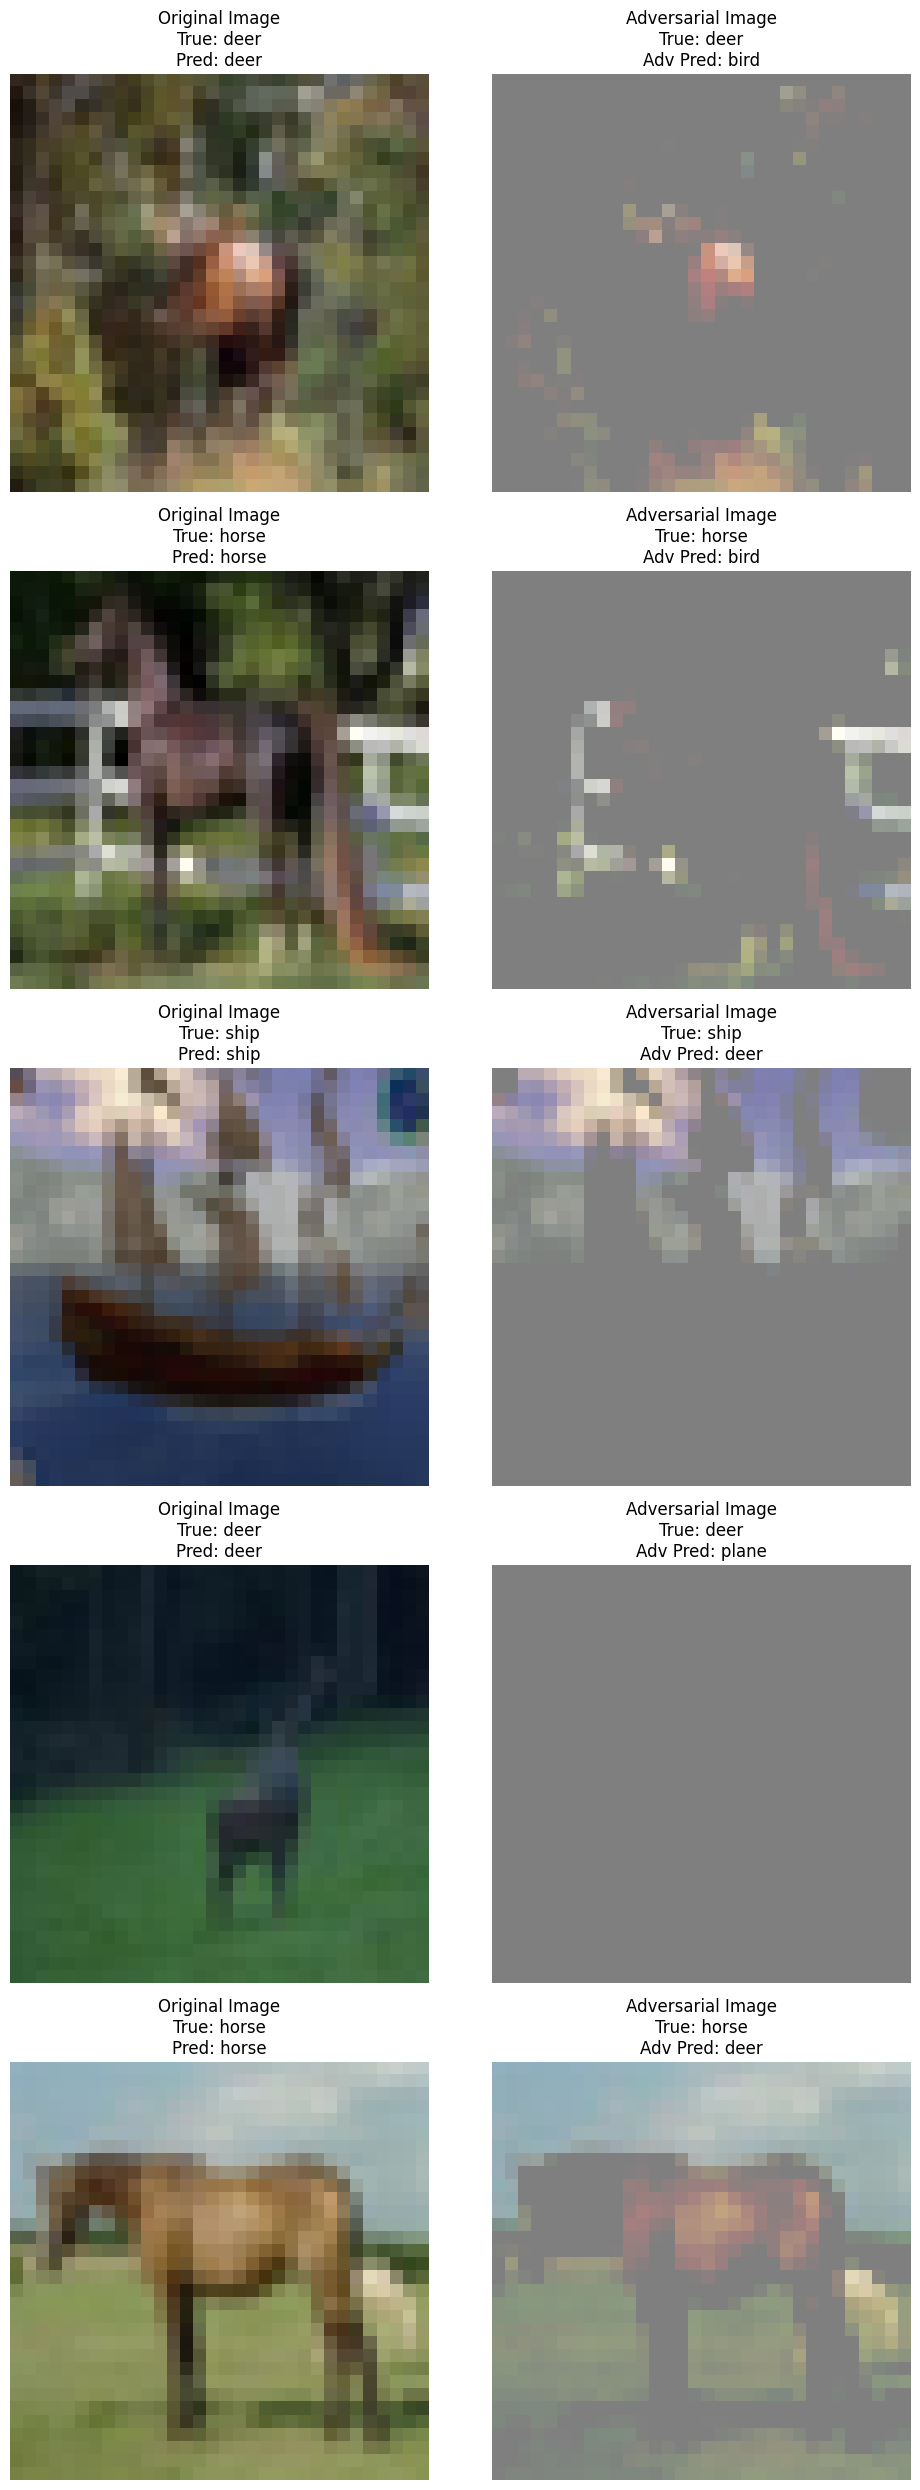

In [22]:
# PGDL2 Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the CW Attack
attack_pgdl2 = torchattacks.PGDL2(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pgdl2(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

Success Rate: 0.4141


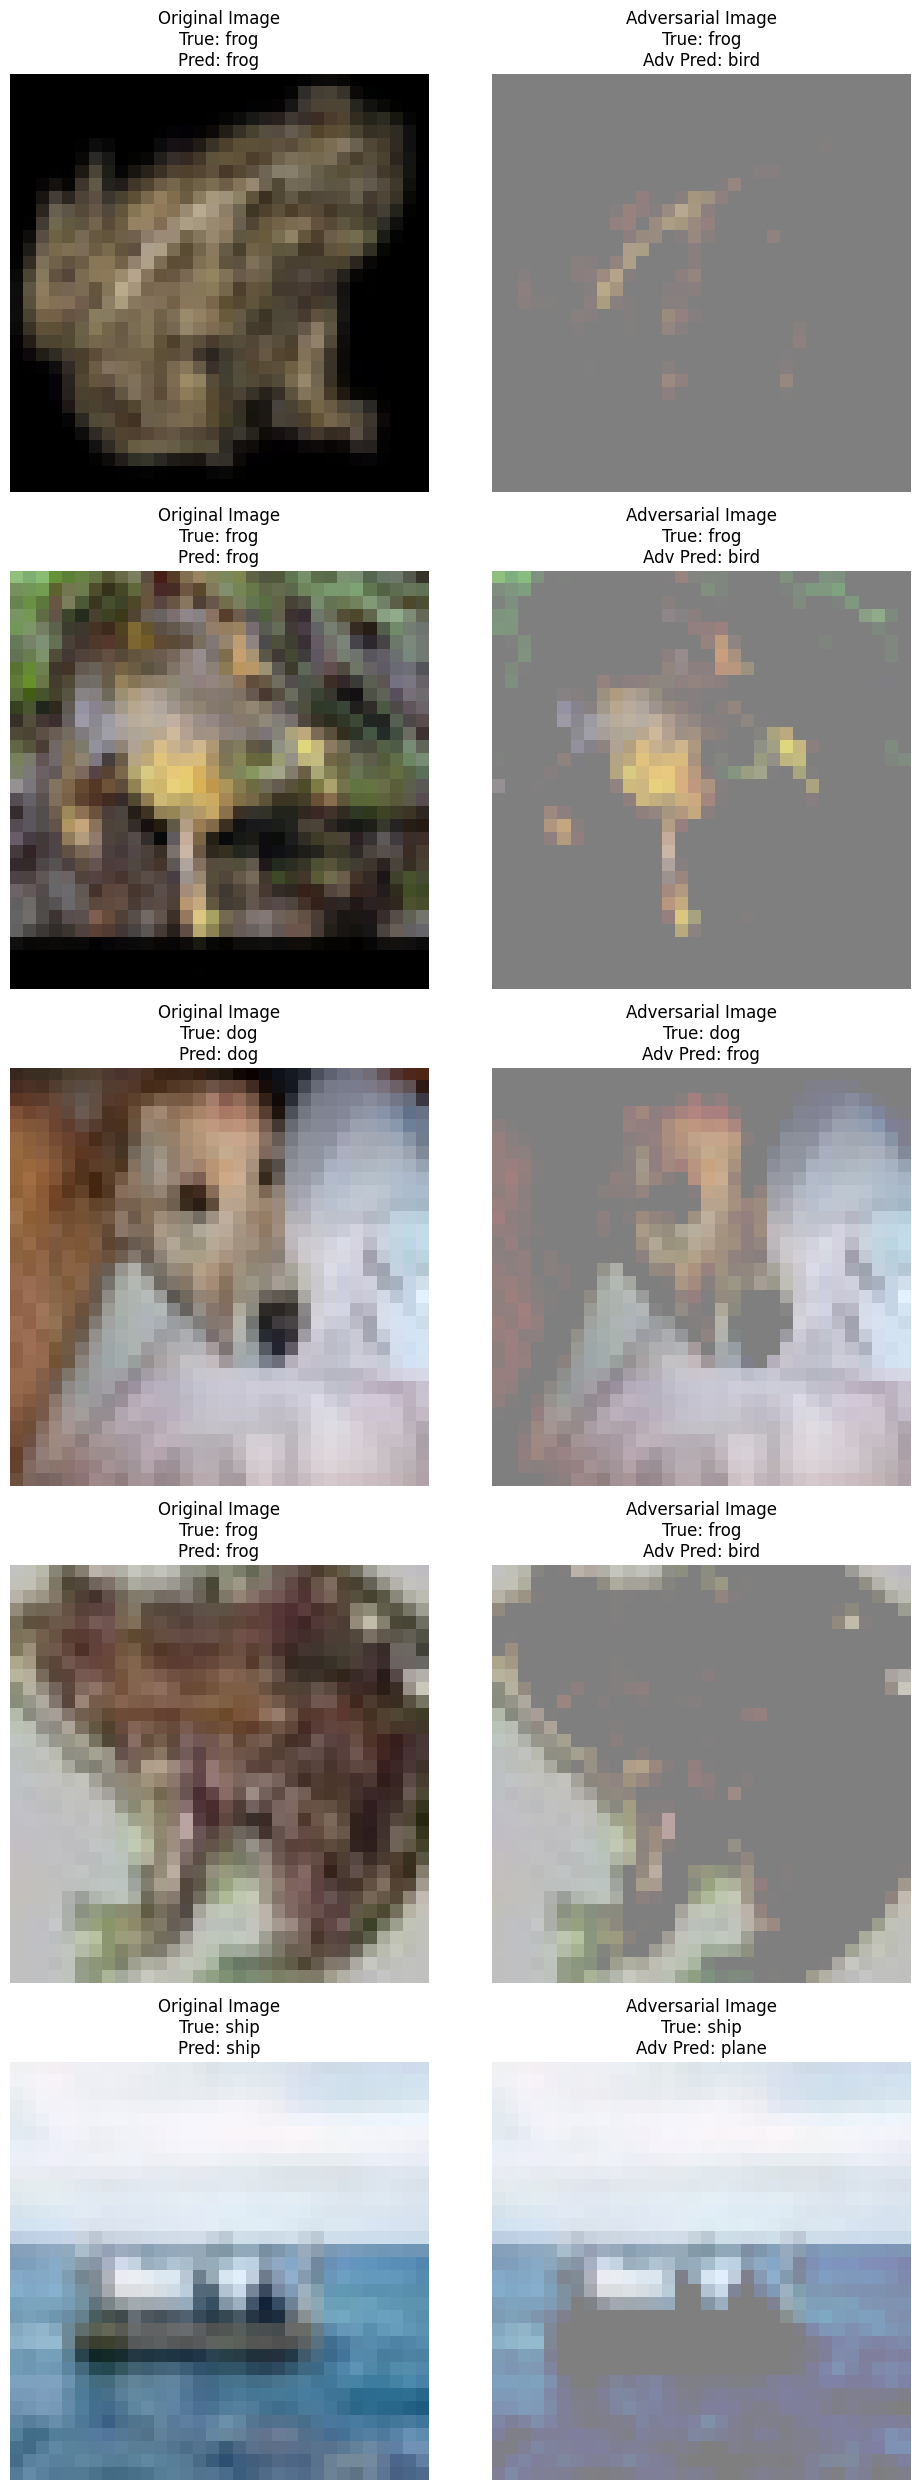

In [23]:
# PGDRSL2 Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the PGDRSL2 Attack
attack_pgdrsl2 = torchattacks.PGDRSL2(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pgdrsl2(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# DeepFool Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the DeepFool Attack
attack_deepfool = torchattacks.DeepFool(model, steps = 50, overshoot = 0.02)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_deepfool(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# SparseFool Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SparseFool Attack
attack_sparsefool = torchattacks.SparseFool(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_sparsefool(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# OnePixel Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the OnePixel Attack
attack_onepix = torchattacks.OnePixel(model, pixels = 1, steps = 10, popsize = 10)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5 # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_onepix(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# FAB Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the PGDRSL2 Attack
attack_fab = torchattacks.FAB(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5 # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_fab(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Pixle Attack

import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Pixle Attack
attack_pix = torchattacks.Pixle(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pix(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)


# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()